In [1]:
using ITensors
using ITensorMPS
using LinearAlgebra
using PolyChaos
using QuadGK
using Plots
using Strided

In [2]:
function spectral_func(input::AbstractString, D::Float64, g::Float64)
    inband = x -> (-D <= x <= D)
        
    if input == "flat"
        J = x -> inband(x) ? 1/(2D) : 0.0
    elseif input == "elliptical"
        J = x -> inband(x) ? sqrt(1 - (x/D)^2) : 0.0
    elseif input == "ohmic"
        J = x -> inband(x) ? abs(x) : 0.0
    elseif input == "lorentzian"
        J = x -> 1/(1 + (x/D)^2)
    else
        error("spectral function type not recognized")
    end
    # normalization
    norm = quadgk(J, -D, D)[1]           
    Jnorm = x -> g*D/pi * J(x) / norm
    return Jnorm
end

function thermofield_transform(J, beta::Float64, mu::Float64) #spectral function, inverse temp, chemical potential
    """thermofield purification using fermi function ancilla"""
    fermi(k) = 1/(1 + exp(beta*k - beta*mu))
    J1 = w -> J(w) * fermi(w) #filled mode spectral density
    J2 = w -> J(w) * (1 - fermi(w)) #empty mode spectral density
    return J1, J2
end

function chain_map(J, N::Int64, D::Float64)
    """calculates family of monic orthogonal polynomials w.r.t the measure J(x) up to the Nth term.
    returns the coefficients alpha and beta from the recurrence relation of the family."""
    supp = (-D, D)
    meas = Measure("bath", J, supp, false, Dict())
    ortho_poly = OrthoPoly("bath_op", N, meas; Nquad=10000)   
    chain = coeffs(ortho_poly)                                  
    Es = chain[1:N,1] #site energies
    ts = sqrt.(chain[1:N,2]) #site hoppings (first term is system hopping)
    return Es, ts
end

function prepare_2body_MPS(N::Int64, sys_state::Vector{String})
    """
    Prepare initial MPS state for 2-body system + Bath
    Sites 1 & 2: System
    Sites 3 to N+2: Filled chain
    Sites N+3 to 2N+2: Empty chain
    """
    
    # Using "Fermion" sites as in your snippet, conserving particle number
    sites = siteinds("Fermion", 2N+2, conserve_qns=true)
    
    # Initialize state array
    # Default: Bath is empty ("Emp"), System is set by sys_state
    states = ["Occ" for _ in 1:2N+2]
    states[4:2:2N+2] .= "Emp"
    
    # Set System States (Site 1 and 2)
    states[1] = sys_state[1]
    states[2] = sys_state[2]
    
    # Optional: Fill half the bath if needed (Fermi sea)
    # for j in 3:2:N_total
    #     states[j] = "Occ"
    # end

    psi0 = MPS(sites, states) 
    return psi0, sites, states
end

function HamiltonianMPO(E_sys, t_sys, V_sys, E1, t1, E2, t2, sites, N)
    
    """
    1 - filled chain
    2 - empty chain

    Fermionic Hamiltonian for 2-body system coupled to a bath chain
    System: Sites 1, 2
    Bath: Sites 3...2N+2
    """

    N_total = length(sites)
    ampo = AutoMPO() 
    
    # --- 1. Internal System Dynamics (Sites 1 & 2) ---
    # Hopping between the two bodies
    add!(ampo, E_sys[1], "N", 1)
    add!(ampo, E_sys[2], "N", 2)

    add!(ampo, t_sys, "Cdag", 1, "C", 2)
    add!(ampo, t_sys, "Cdag", 2, "C", 1)
    
    # Interaction term (e.g., Coulomb repulsion V * n1 * n2)
    add!(ampo, V_sys, "N", 1, "N", 2)
    
    #system-filled chain coupling
    add!(ampo, t1[1], "Cdag", 2, "C", 3)
    add!(ampo, t1[1], "Cdag", 3, "C", 2)

    #system-empty chain coupling
    add!(ampo, t2[1], "Cdag", 2, "C", 4)
    add!(ampo, t2[1], "Cdag", 4, "C", 2)
    
    for j in 1:N
        add!(ampo, E1[j], "N", 2 + 2j-1)
        add!(ampo, E2[j], "N", 2 + 2j)
    end
    for j in 2:N
        add!(ampo, t1[j], "Cdag", 2j-1, "C", 2j+1 )
        add!(ampo, t1[j], "Cdag", 2j+1, "C", 2j-1)
        add!(ampo, t2[j], "Cdag", 2j, "C", 2j+2)
        add!(ampo, t2[j], "Cdag", 2j+2, "C", 2j)
    end
    return MPO(ampo, sites)
end

function evolve_MPS(psi0::MPS, H::MPO, dt::Float64, tmax::Float64)
    """Time evolve MPS with Hamiltonian MPO using TDVP"""
    psi = psi0
    ts = collect(dt:dt:tmax)
    len = length(ts)
    nSys1 = zeros(len)
    nSys2 = zeros(len)
    num = zeros(2N+1)
    for k in 1:len
        psi = tdvp(H, -im*dt, psi; nsite=2, outputlevel=1, mindim=1, maxdim=1000) #time_step=dt, nsweeps=sweeps, order=2)
        nSys1[k] = expect(psi, "N"; sites=1)[1]
        nSys2[k] = expect(psi, "N"; sites=2)[1]
        println("timestep $k of $len complete")
    end
    return nSys1, nSys2
end


evolve_MPS (generic function with 1 method)

In [ ]:
D = 1.0
mu = 0.0
N = 20
g = 0.1
beta = 10.0

E_sys = [0.0, 0.0] #system site energies
t_sys = 0.1 #system site hopping
V_sys = 0.0 #coulomb repulsion

dt = 0.1
tmax = 20.0


J = spectral_func("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)
E1, t1 = chain_map(J1, N, D)
E2, t2 = chain_map(J2, N, D)

psi0, sites, states = prepare_2body_MPS(N, ["Occ", "Emp"])
H = HamiltonianMPO(E_sys, t_sys, V_sys, E1, t1, E2, t2, sites, N)

nSys1, nSys2 = evolve_MPS(psi0, H, dt, tmax)

After sweep 1: maxlinkdim=4 maxerr=1.23E-16 current_time=0.0 - 0.1im time=49.285
timestep 1 of 200 complete
After sweep 1: maxlinkdim=5 maxerr=8.55E-18 current_time=0.0 - 0.1im time=1.46
timestep 2 of 200 complete
After sweep 1: maxlinkdim=5 maxerr=1.48E-16 current_time=0.0 - 0.1im time=0.108
timestep 3 of 200 complete
After sweep 1: maxlinkdim=5 maxerr=5.35E-18 current_time=0.0 - 0.1im time=0.115
timestep 4 of 200 complete
After sweep 1: maxlinkdim=5 maxerr=1.28E-16 current_time=0.0 - 0.1im time=0.178
timestep 5 of 200 complete
After sweep 1: maxlinkdim=5 maxerr=4.23E-17 current_time=0.0 - 0.1im time=0.16
timestep 6 of 200 complete
After sweep 1: maxlinkdim=6 maxerr=2.05E-16 current_time=0.0 - 0.1im time=0.956
timestep 7 of 200 complete
After sweep 1: maxlinkdim=7 maxerr=1.85E-16 current_time=0.0 - 0.1im time=0.255
timestep 8 of 200 complete
After sweep 1: maxlinkdim=7 maxerr=1.74E-16 current_time=0.0 - 0.1im time=0.289
timestep 9 of 200 complete
After sweep 1: maxlinkdim=7 maxerr=4.3

([0.9999000090520028, 0.9996001538126928, 0.9991007921206551, 0.9984025192679931, 0.9975061654750959, 0.9964127927316963, 0.9951236907745784, 0.9936403722377842, 0.9919645670000136, 0.990098215846989  …  0.34934300094971027, 0.35115297684950125, 0.3529995070609318, 0.3548813176108553, 0.35679713670702334, 0.35874570157515906, 0.3607257556568368, 0.3627360495731136, 0.36477534257936123, 0.36684239983135924], [0.0002590962077379441, 0.0010355732657357337, 0.002326946666285193, 0.004129090644597899, 0.0064362685677689085, 0.009241173173587462, 0.012534977044954081, 0.016307392776641488, 0.02054674262356001, 0.025240036739805415  …  0.5901250216079952, 0.5870044388577997, 0.5838886750980365, 0.580778821822881, 0.5776759329718963, 0.5745810273679498, 0.5714950916021209, 0.5684190828822591, 0.5653539317964138, 0.5623005457750864])

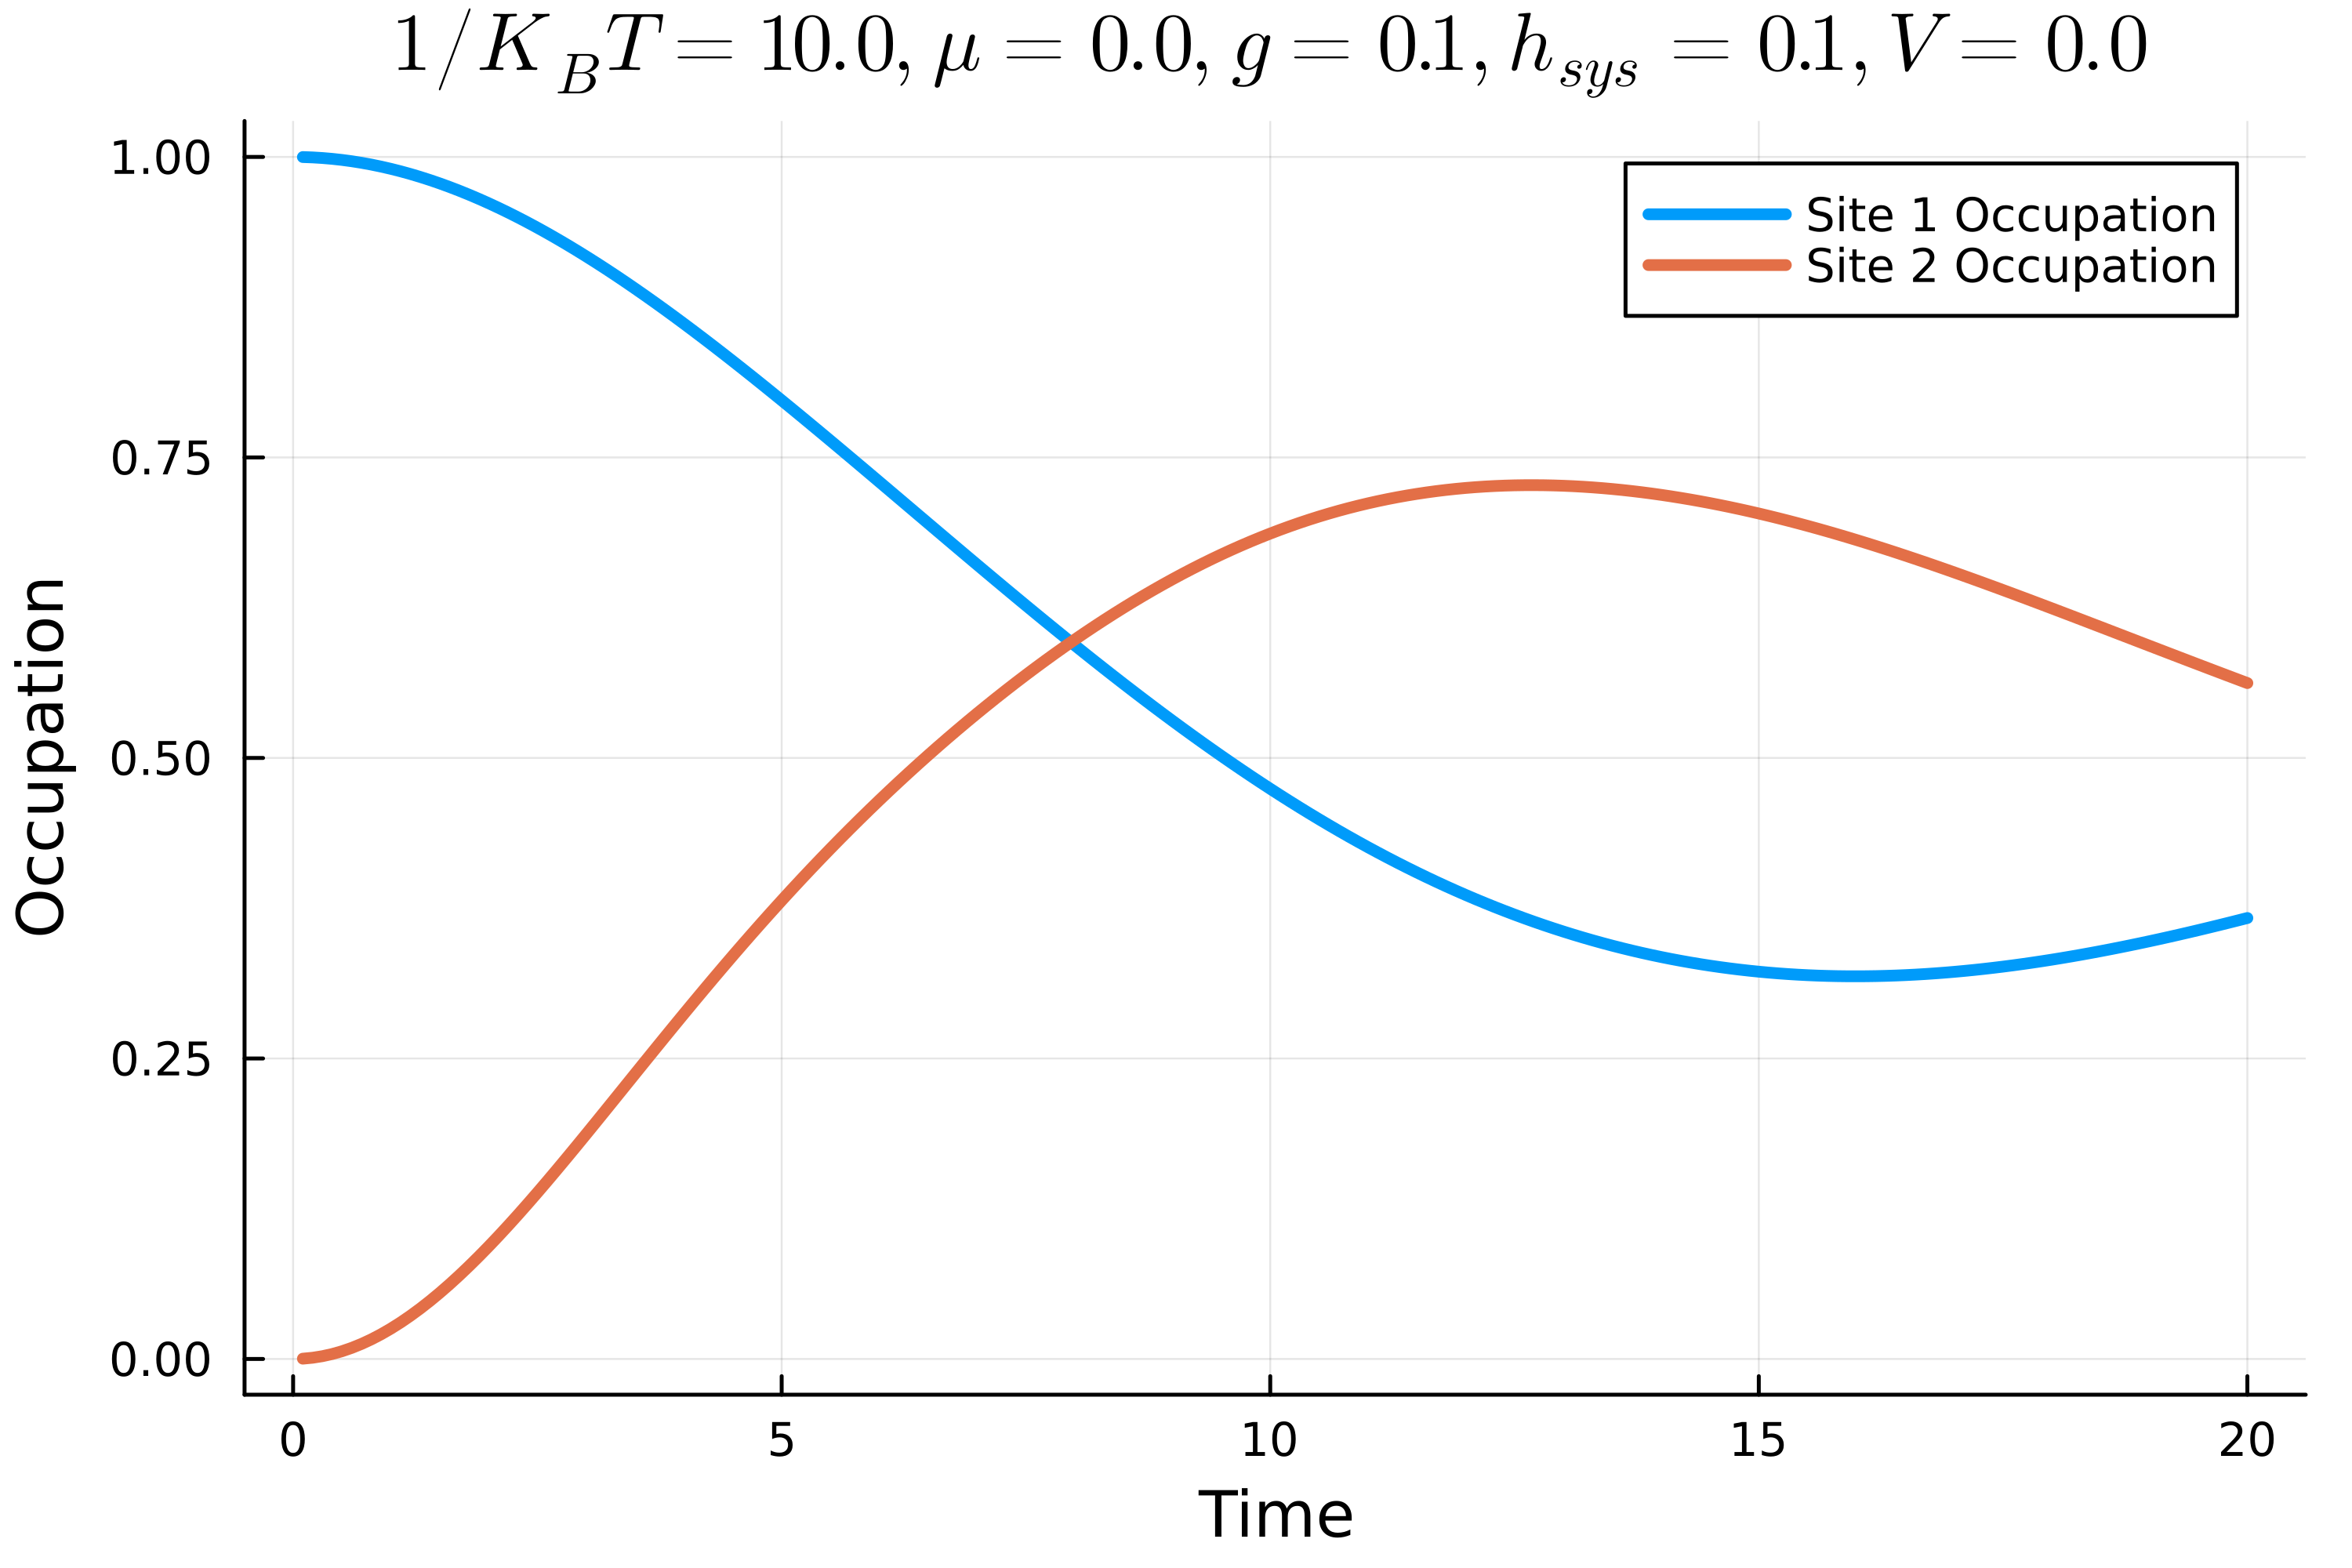

"c:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\2ndTerm\\test.png"

In [4]:
p1 = plot(collect(dt:dt:tmax), nSys1, label="Site 1 Occupation", xlabel="Time", ylabel="Occupation", title="\$1/K_B T=$beta, \\mu=$mu, g=$g, h_{sys} = $t_sys, V=$V_sys\$", lw=3)
plot!(p1, collect(dt:dt:tmax), nSys2, label="Site 2 Occupation", dpi=500, lw=3)

display(p1)
savefig("test.png")

In [10]:
sys_size=2

function prepare_corrs(N, sys_occs; n_sites=sys_size)
    N_tot = 2N + n_sites
    C = zeros(ComplexF64, N_tot, N_tot)
    for n in 1:n_sites
        C[n,n] = sys_occs[n]
    end
    for n in 1:N
        C[n_sites + 2n - 1, n_sites + 2n - 1] = 1.0
        C[n_sites + 2n, n_sites + 2n] = 0.0
    end
    return C
end


function HamiltonianCorrs(N, H_sys, E1, t1, E2, t2; n_sites=sys_size)
    N_tot = 2N + n_sites
    H = zeros(ComplexF64, N_tot, N_tot)
    for n in 1:n_sites
        for m in 1:n_sites
            H[n,m] = H_sys[n,m]
        end
    end

    #nth system site coupling to bath
    H[n_sites,n_sites+1] = t1[1]
    H[n_sites+1,n_sites] = t1[1]
    H[n_sites,n_sites+2] = t2[1]
    H[n_sites+2,n_sites] = t2[1]

    for n in 1:N
        H[2n-1+n_sites, 2n-1+n_sites] = E1[n]
        H[2n+n_sites, 2n+n_sites] = E2[n]
    end
    for n in 2:N
        H[2n-1,2n+1] = t1[n]
        H[2n+1,2n-1] = t1[n]
        H[2n, 2n+2] = t2[n]
        H[2n+2, 2n] = t2[n]
    end
    return H
end

function evolve_corrs(C0, H, dt, tmax)
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im*t*H)
        C = U * C0 * U'
        push!(Cs, C)
    end
    return Cs
end

evolve_corrs (generic function with 1 method)

In [11]:

#system params
sys_occs = [1.0, 0.0]
H_sys = [0.0 0.1; 0.1 0.0]
@assert issymmetric(H_sys) == true

J = spectral_func("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)

E1, t1 = chain_map(J1, N, D)
E2, t2 = chain_map(J2, N, D)

H = HamiltonianCorrs(N, H_sys, E1, t1, E2, t2)
C0 = prepare_corrs(N,sys_occs)
Cs = evolve_corrs(C0, H, dt, tmax)

201-element Vector{Array{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.9999000099635151 + 0.0im -5.359801954799658e-9 + 0.009998007424265636im … 1.0594910874418019e-46 + 6.510183231696043e-45im -1.2759335613824946e-47 + 8.474982346062834e-46im; -5.359801954799658e-9 - 0.009998007424265636im 0.00025908566606419305 + 0.0im … -6.509343020242498e-43 + 1.0593684194097521e-44im 2.1957424214497457e-47 + 5.3755366005560674e-49im; … ; 1.0594910874418019e-46 - 6.510183231696043e-45im -6.509343020242498e-43 - 1.0593684194097521e-44im … 1.0 + 0.0im -2.1188109485110545e-85 - 6.898256697528185e-87im; -1.2759335613824946e-47 - 8.474982346062836e-46im 2.1957424214497457e-47 - 5.3755366005560674e-49im … -2.1188109485110583e-85 + 6.898256697528185e-87im 1.8622462865738816e-90 - 3.4839875141519556e-109im]
 [0.9996001593551374

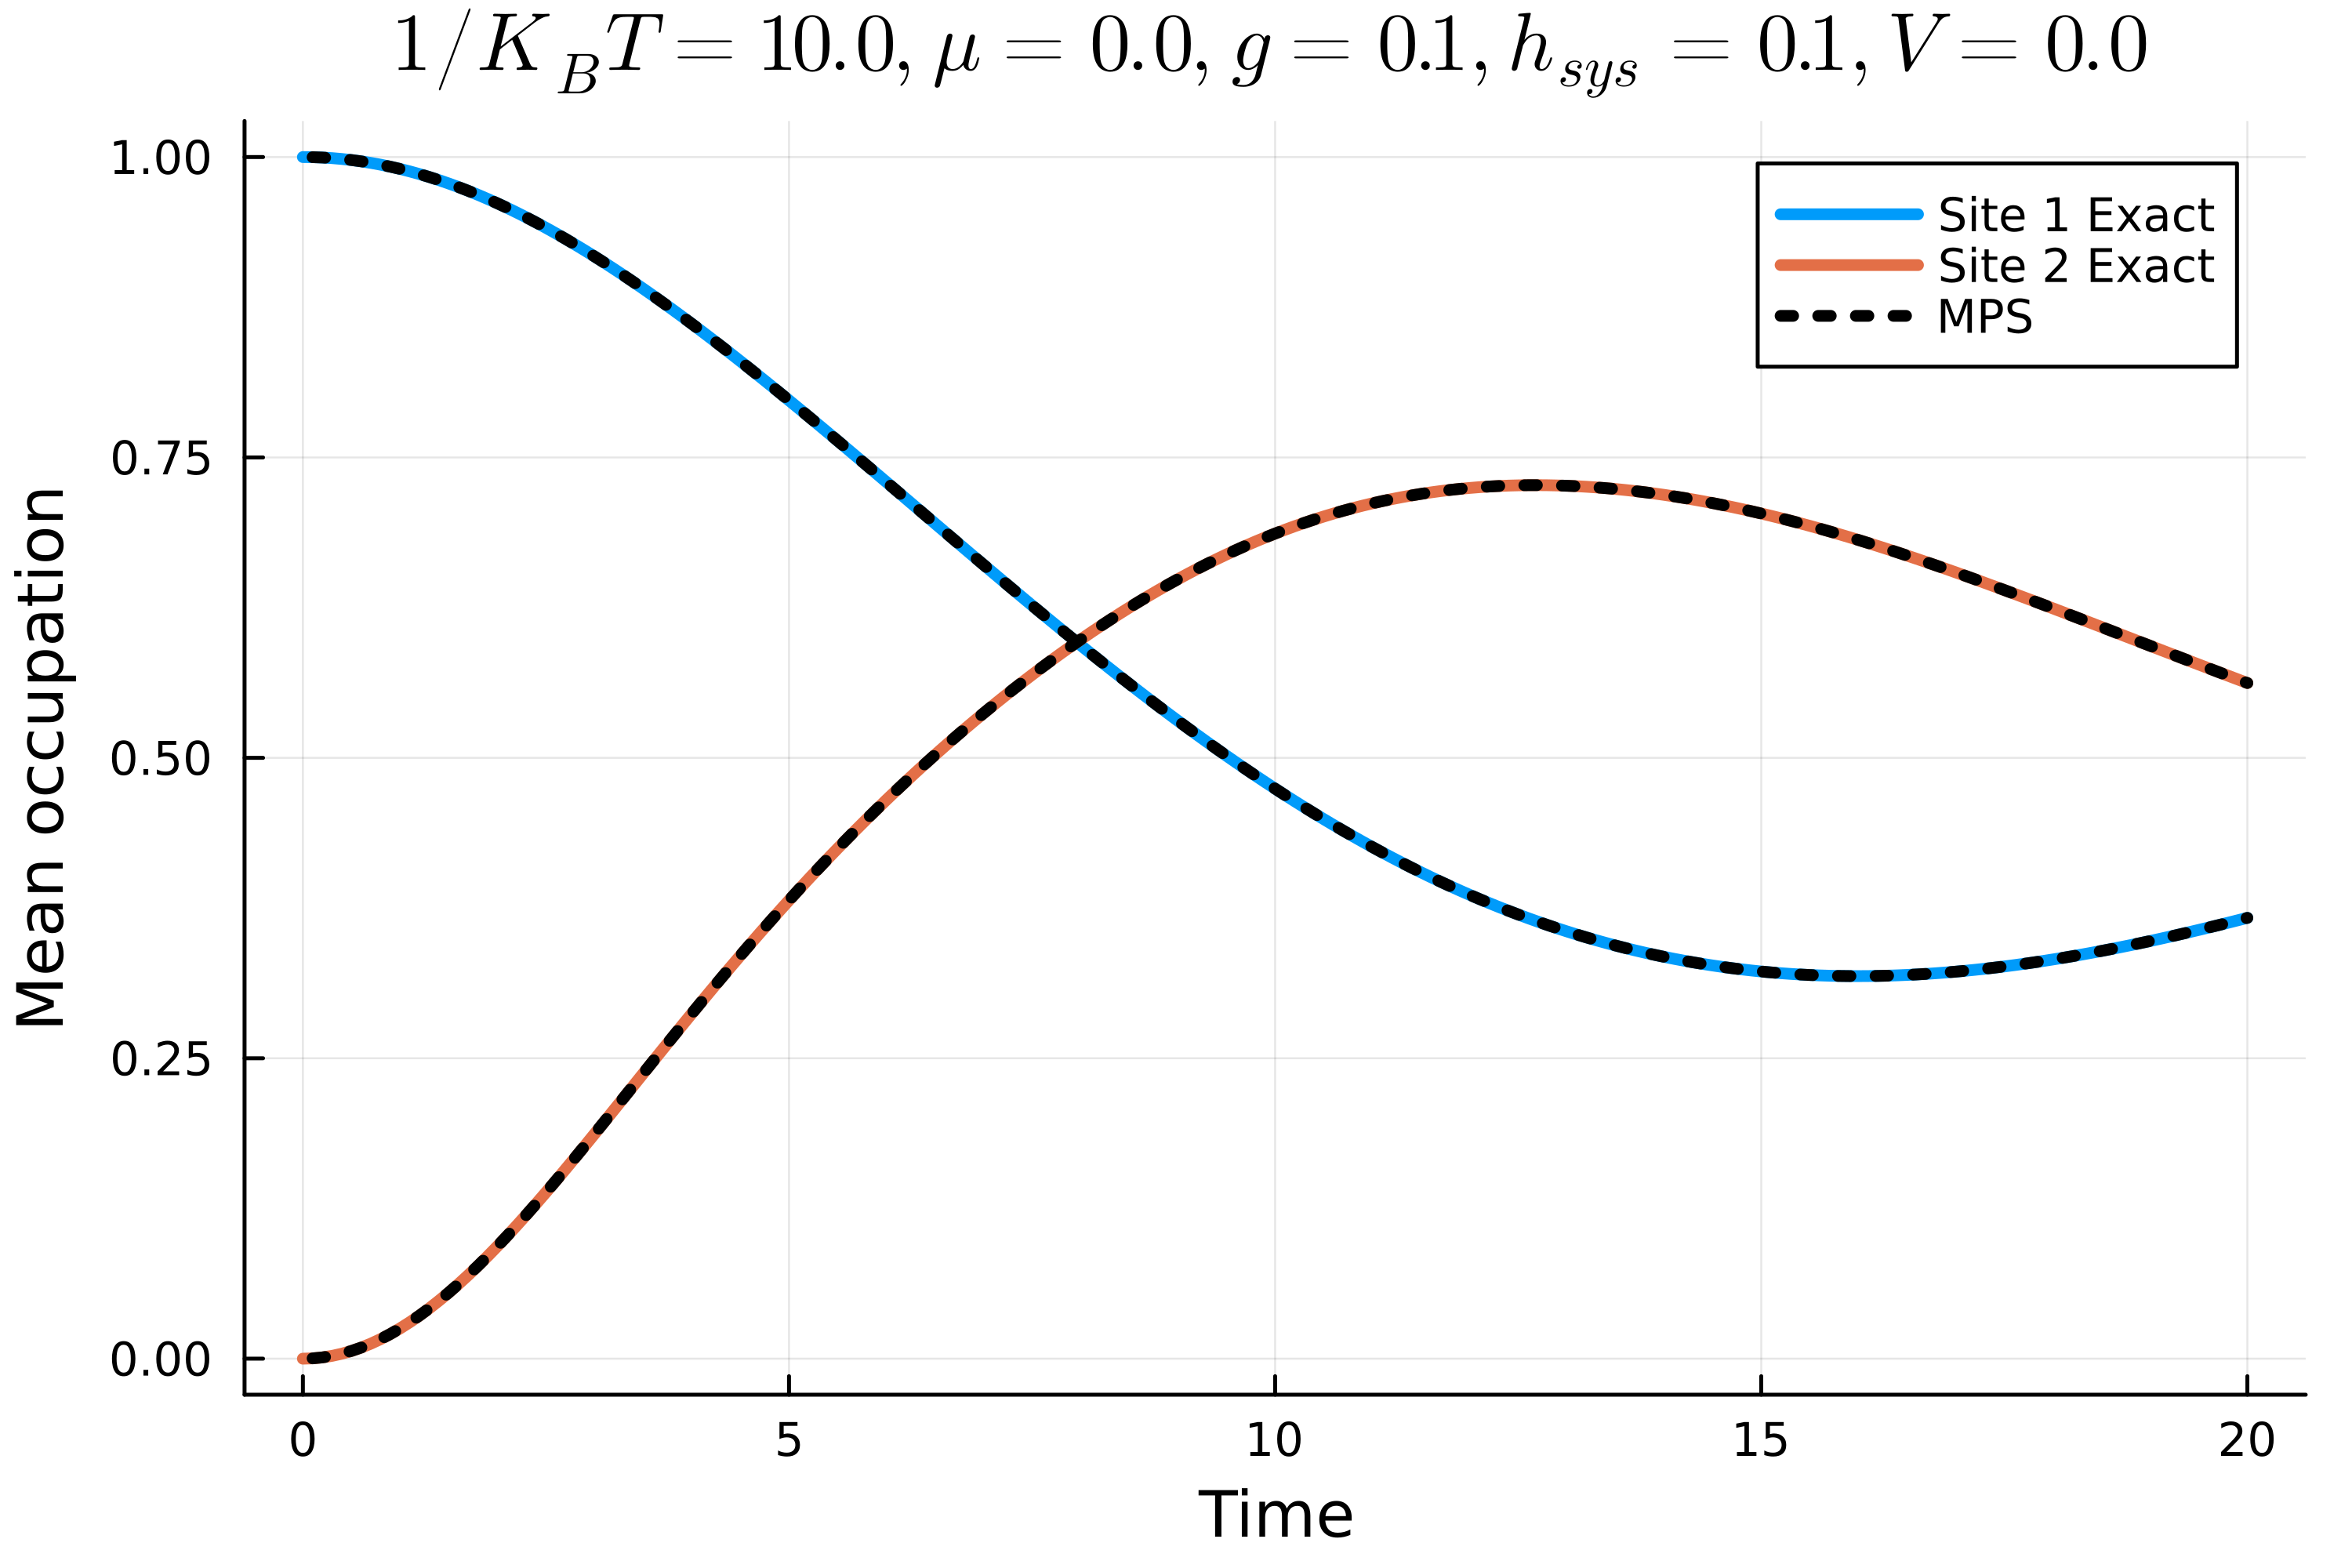

"c:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\2ndTerm\\2body_MPS_Exact.png"

In [14]:
occ1 = zeros(length(Cs))
occ2 = zeros(length(Cs))
for (t,C) in enumerate(Cs)
    occ1[t] = real(C[1,1])
    occ2[t] = real(C[2,2])
end

p = plot(0:dt:tmax, occ1, label="Site 1 Exact", xlabel="Time", ylabel="Mean occupation", title="\$1/K_B T=$beta, \\mu=$mu, g=$g, h_{sys} = $t_sys, V=$V_sys\$", lw=3)
plot!(p, 0:dt:tmax, occ2, label="Site 2 Exact", dpi=500, lw=3)
plot!(p, dt:dt:tmax, nSys1, label="MPS", linestyle=:dot, lw=3, c=:black)
plot!(p, dt:dt:tmax, nSys2, label="", linestyle=:dot, lw=3, c=:black)

display(p) 
savefig("2body_MPS_Exact.png")